# Data Wrangling - Redfin Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import category_encoders as ce

In [2]:
#concatenating downloaded csv files from Redfin
#Redfin has download limit of 350 records
#to get around this I used the following criteria in my search:
    #searched by zipcode, houses sold in the last 3 months
df = pd.concat(map(pd.read_csv, glob.glob('../data/raw/redfin_data/*.csv')))

# Exploring the data

In [3]:
#get a general sense of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16489 entries, 0 to 274
Data columns (total 27 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   SALE TYPE                                                                                   16489 non-null  object 
 1   SOLD DATE                                                                                   14741 non-null  object 
 2   PROPERTY TYPE                                                                               16489 non-null  object 
 3   ADDRESS                                                                                     16486 non-null  object 
 4   CITY                                                                                        16489 non-null  object 
 5   STATE OR PROVINCE                        

In [4]:
df.head()

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,PAST SALE,April-13-2021,Single Family Residential,9329 Sienna Vista Dr,Las Vegas,NV,89117,621500,4.0,2.50,...,Sold,NaN,NaN,http://www.redfin.com/NV/Las-Vegas/9329-Sienna...,GLVAR,2278835.0,N,Y,36.154483,-115.297871
1,PAST SALE,March-19-2021,Single Family Residential,3358 Wardlaw St,Las Vegas,NV,89117,400000,4.0,3.00,...,Sold,NaN,NaN,http://www.redfin.com/NV/Las-Vegas/3358-Wardla...,GLVAR,2271023.0,N,Y,36.128126,-115.263408
2,PAST SALE,NaN,Single Family Residential,3367 Ceremony Dr,Las Vegas,NV,89117,339000,4.0,2.50,...,NaN,NaN,NaN,http://www.redfin.com/NV/Las-Vegas/3367-Ceremo...,NaN,NaN,N,Y,36.127931,-115.263037
3,PAST SALE,NaN,Single Family Residential,1680 City View Ct,Las Vegas,NV,89117,818000,4.0,5.00,...,NaN,NaN,NaN,http://www.redfin.com/NV/Las-Vegas/1680-City-V...,NaN,NaN,N,Y,36.151716,-115.268710
4,PAST SALE,March-24-2021,Townhouse,972 Prestwick St,Las Vegas,NV,89145,335000,3.0,2.75,...,Sold,NaN,NaN,http://www.redfin.com/NV/Las-Vegas/972-Prestwi...,GLVAR,2274031.0,N,Y,36.160917,-115.294868


# Dropping unnecessary columns

In [5]:
#drop the columns that are not useful or interpretable
df = df.drop(columns=['SOLD DATE', 'SALE TYPE', 'STATE OR PROVINCE', 'STATUS', 'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME', 'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)', 'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED'])

In [6]:
#df = df[df['PRICE'] <= 1000000]

In [7]:
df.head()

,PROPERTY TYPE,ADDRESS,CITY,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE
0,Single Family Residential,9329 Sienna Vista Dr,Las Vegas,89117,621500,4.0,2.50,Sienna Ridge,2352.0,6098.0,1994.0,19.0,264.0,146.0,36.154483,-115.297871
1,Single Family Residential,3358 Wardlaw St,Las Vegas,89117,400000,4.0,3.00,Cimarron Village #2-Lewis Homes,1883.0,3920.0,1995.0,44.0,212.0,NaN,36.128126,-115.263408
2,Single Family Residential,3367 Ceremony Dr,Las Vegas,89117,339000,4.0,2.50,NaN,2230.0,4356.0,1995.0,NaN,152.0,NaN,36.127931,-115.263037
3,Single Family Residential,1680 City View Ct,Las Vegas,89117,818000,4.0,5.00,NaN,4863.0,20038.0,1993.0,NaN,168.0,NaN,36.151716,-115.268710
4,Townhouse,972 Prestwick St,Las Vegas,89145,335000,3.0,2.75,Queensridge Fairway Homes-Phase 3,1613.0,2614.0,2001.0,39.0,208.0,175.0,36.160917,-115.294868


# Cleaning up 'Property Type' column

In [8]:
#look at the unique values in the 'Property Type' column, will break these out into columns later
print(df['PROPERTY TYPE'].unique())

['Single Family Residential' 'Townhouse' 'Multi-Family (2-4 Unit)'
 'Condo/Co-op' 'Mobile/Manufactured Home' 'Other' 'Vacant Land'
 'Multi-Family (5+ Unit)']


In [9]:
df['PROPERTY TYPE'].value_counts()

Single Family Residential    12110
Condo/Co-op                   2554
Townhouse                     1428
Multi-Family (2-4 Unit)        206
Mobile/Manufactured Home       172
Other                           12
Vacant Land                      4
Multi-Family (5+ Unit)           3
Name: PROPERTY TYPE, dtype: int64

In [10]:
#drop if 'Property Type' == 'Multi-Family (2-4 Unit)', 'Other', 'Vacant Land', 'Multi-Family (5+ Unit)'
df = df[df['PROPERTY TYPE'] != 'Other']
df = df[df['PROPERTY TYPE'] != 'Multi-Family (2-4 Unit)']
df = df[df['PROPERTY TYPE'] != 'Vacant Land']
df = df[df['PROPERTY TYPE'] != 'Multi-Family (5+ Unit)']
df = df[df['PROPERTY TYPE'] != 'Mobile/Manufactured Home']

df['PROPERTY TYPE'].value_counts()

Single Family Residential    12110
Condo/Co-op                   2554
Townhouse                     1428
Name: PROPERTY TYPE, dtype: int64

I'm thinking of binning Condo and Townhouse to lessen the number of features later on when I encode the Property Type column. To help me make a decision, I have pasted the definitions that RedFin uses for all 3 property types below (taken from the RedFin RealEstate Glossary available online at https://www.redfin.com/real-estate-glossary#S).

Definition of Single Family Residence (SFR) - the most common type of home listed in the MLS. Also known as single family detached, this means the home is a stand-alone structure with its own lot intended for one family. Single family residences differ from condominiums, townhomes, cooperatives, and multi-family homes, which are all attached residences.

Definition of Townhouse - a type of home that's usually constructed as a two- or three-story unit with a common wall or walls bordering the adjacent unit. The common form of ownership is similar to a condominium project, in that the property owner not only owns his or her respective unit, but also owns an undivided interest in any common area. Townhouse ownership sometimes differs from condominium ownership in that the townhouse owner owns the physical structure rather than just the airspace between the walls, floor and ceiling. However, in some areas "townhouse" can refer to the physical style of the structure rather than the form of ownership.

Definition of Condominium - a unit that you own within a multi-unit complex such as an apartment building. While each condo is individually owned, the common spaces are collectively owned and shared by all the owners in the complex. Condo developments are managed by homeowners associations that collect monthly dues, maintain operations, and enforce policies. Condo buildings are different from co-ops. With a co-op, the homeowners own shares in the corporation that owns the building, rather than owning units themselves. Co-op owners receive the right to live in a specific unit and enjoy common spaces in accordance with a written lease agreement.


Based on my research, I feel comfortable combining the Condo and Townhouse property types. The main difference between Condos/Townhouses and Single-Family Residences is that the Single-Family Residences are detached. Limiting the number of features will also help any model I choose to use later on. 

In [11]:
#I'm going to bin Condo and Townhouse because they are similar property types and this will be helpful later on
conditions = [
    df['PROPERTY TYPE'].str.contains('Single Family Residential'),
    df['PROPERTY TYPE'].str.contains('Condo/Co-op'),
    df['PROPERTY TYPE'].str.contains('Townhouse')]
choices = ['SingleFamily', 'Condo/Townhouse', 'Condo/Townhouse']
df['property_type'] = np.select(conditions, choices)
df = df.drop(columns=['PROPERTY TYPE'])
df.head()

,ADDRESS,CITY,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,property_type
0,9329 Sienna Vista Dr,Las Vegas,89117,621500,4.0,2.50,Sienna Ridge,2352.0,6098.0,1994.0,19.0,264.0,146.0,36.154483,-115.297871,SingleFamily
1,3358 Wardlaw St,Las Vegas,89117,400000,4.0,3.00,Cimarron Village #2-Lewis Homes,1883.0,3920.0,1995.0,44.0,212.0,NaN,36.128126,-115.263408,SingleFamily
2,3367 Ceremony Dr,Las Vegas,89117,339000,4.0,2.50,NaN,2230.0,4356.0,1995.0,NaN,152.0,NaN,36.127931,-115.263037,SingleFamily
3,1680 City View Ct,Las Vegas,89117,818000,4.0,5.00,NaN,4863.0,20038.0,1993.0,NaN,168.0,NaN,36.151716,-115.268710,SingleFamily
4,972 Prestwick St,Las Vegas,89145,335000,3.0,2.75,Queensridge Fairway Homes-Phase 3,1613.0,2614.0,2001.0,39.0,208.0,175.0,36.160917,-115.294868,Condo/Townhouse


# Dropping duplicate rows

In [12]:
#drop the duplicate rows
df.drop_duplicates(subset=['ADDRESS'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13515 entries, 0 to 157
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ADDRESS             13514 non-null  object 
 1   CITY                13515 non-null  object 
 2   ZIP OR POSTAL CODE  13515 non-null  int64  
 3   PRICE               13515 non-null  int64  
 4   BEDS                13492 non-null  float64
 5   BATHS               13492 non-null  float64
 6   LOCATION            11991 non-null  object 
 7   SQUARE FEET         13497 non-null  float64
 8   LOT SIZE            11928 non-null  float64
 9   YEAR BUILT          13514 non-null  float64
 10  DAYS ON MARKET      12174 non-null  float64
 11  $/SQUARE FEET       13497 non-null  float64
 12  HOA/MONTH           8920 non-null   float64
 13  LATITUDE            13515 non-null  float64
 14  LONGITUDE           13515 non-null  float64
 15  property_type       13515 non-null  object 
dtypes: flo

# Dealing with NaNs (Part 1)

In [13]:
#total nans in each column of the df, will use this information to determine how to address the nans
df.isna().sum()

ADDRESS                  1
CITY                     0
ZIP OR POSTAL CODE       0
PRICE                    0
BEDS                    23
BATHS                   23
LOCATION              1524
SQUARE FEET             18
LOT SIZE              1587
YEAR BUILT               1
DAYS ON MARKET        1341
$/SQUARE FEET           18
HOA/MONTH             4595
LATITUDE                 0
LONGITUDE                0
property_type            0
dtype: int64

In [14]:
#dealing with nans
#dropping the 1 row with missing address
df.dropna(subset=['ADDRESS'], inplace=True)

In [15]:
#probably won't use the location, because zipcode is also representative of the location, location has too many unique values
df.LOCATION.nunique()

4899

In [16]:
#I'm going to drop the location column. I don't think its interpretable because of the number of unique values. 
df = df.drop(columns=['LOCATION'])
df.head()

,ADDRESS,CITY,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,property_type
0,9329 Sienna Vista Dr,Las Vegas,89117,621500,4.0,2.50,2352.0,6098.0,1994.0,19.0,264.0,146.0,36.154483,-115.297871,SingleFamily
1,3358 Wardlaw St,Las Vegas,89117,400000,4.0,3.00,1883.0,3920.0,1995.0,44.0,212.0,NaN,36.128126,-115.263408,SingleFamily
2,3367 Ceremony Dr,Las Vegas,89117,339000,4.0,2.50,2230.0,4356.0,1995.0,NaN,152.0,NaN,36.127931,-115.263037,SingleFamily
3,1680 City View Ct,Las Vegas,89117,818000,4.0,5.00,4863.0,20038.0,1993.0,NaN,168.0,NaN,36.151716,-115.268710,SingleFamily
4,972 Prestwick St,Las Vegas,89145,335000,3.0,2.75,1613.0,2614.0,2001.0,39.0,208.0,175.0,36.160917,-115.294868,Condo/Townhouse


In [17]:
#evaluating progress
df.isna().sum()

ADDRESS                  0
CITY                     0
ZIP OR POSTAL CODE       0
PRICE                    0
BEDS                    23
BATHS                   23
SQUARE FEET             18
LOT SIZE              1587
YEAR BUILT               1
DAYS ON MARKET        1340
$/SQUARE FEET           18
HOA/MONTH             4594
LATITUDE                 0
LONGITUDE                0
property_type            0
dtype: int64

In [18]:
df[df['SQUARE FEET'].isna()]

,ADDRESS,CITY,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,property_type
132,1843 Jefferson St,North Las Vegas,89030,575000,NaN,NaN,NaN,NaN,1979.0,NaN,NaN,NaN,36.193700,-115.126729,Condo/Townhouse
62,5658 S Chippewa St,Pahrump,89061,243225,NaN,NaN,NaN,8276.0,NaN,NaN,NaN,NaN,36.136599,-115.948433,SingleFamily
31,321 N 9th St,Las Vegas,89101,1300000,NaN,NaN,NaN,NaN,2002.0,NaN,NaN,NaN,36.170543,-115.134466,Condo/Townhouse
64,2213 Sunrise Ave,Las Vegas,89101,800000,NaN,NaN,NaN,NaN,1957.0,NaN,NaN,NaN,36.162472,-115.118622,Condo/Townhouse
88,225 Flower Ave,Las Vegas,89101,3865000,NaN,NaN,NaN,NaN,1963.0,NaN,NaN,NaN,36.165665,-115.117437,Condo/Townhouse
100,2640 Marlin Ave,Las Vegas,89101,11040000,NaN,NaN,NaN,NaN,1962.0,NaN,NaN,NaN,36.167164,-115.113550,Condo/Townhouse
127,2215 Stewart Ave,Las Vegas,89101,490000,NaN,NaN,NaN,NaN,1978.0,NaN,NaN,NaN,36.166818,-115.119016,Condo/Townhouse
19,239 W New York Ave,Las Vegas,89102,600000,NaN,NaN,NaN,NaN,1961.0,NaN,NaN,NaN,36.150744,-115.159527,Condo/Townhouse
70,201 W St Louis Ave,Las Vegas,89102,293425,NaN,NaN,NaN,NaN,1954.0,NaN,NaN,NaN,36.148058,-115.158383,Condo/Townhouse
20,2308 Clifford Ave,Las Vegas,89104,544385,NaN,NaN,NaN,NaN,1962.0,NaN,NaN,NaN,36.155311,-115.116051,Condo/Townhouse


In [19]:
#the rows with nans in 'Square Feet' column also have a lot of other missing data, so I've decided to drop these records altogether
df.dropna(subset=['SQUARE FEET'], inplace=True)

In [20]:
df.isna().sum()

ADDRESS                  0
CITY                     0
ZIP OR POSTAL CODE       0
PRICE                    0
BEDS                     5
BATHS                    5
SQUARE FEET              0
LOT SIZE              1570
YEAR BUILT               0
DAYS ON MARKET        1322
$/SQUARE FEET            0
HOA/MONTH             4576
LATITUDE                 0
LONGITUDE                0
property_type            0
dtype: int64

In [21]:
#I'm also dropping all rows with nans in the 'BEDS' or 'BATHS' column. Just based on intiution I think these will be problematic later.
df.dropna(subset=['BEDS', 'BATHS'], inplace=True)
#checking for outliers/mistakes in listing
df.BEDS.value_counts()

3.0     5718
4.0     3347
2.0     2767
5.0      977
1.0      429
6.0      150
0.0       70
7.0       21
8.0        7
9.0        1
10.0       1
Name: BEDS, dtype: int64

In [22]:
#checking for outliers/mistakes in listing
df.BATHS.value_counts()

2.00     4164
2.50     3715
3.00     1218
1.75     1107
1.00      660
2.75      577
3.50      557
2.25      330
1.50      235
4.50      228
4.00      173
3.25      157
3.75       89
4.25       55
5.50       51
5.00       38
5.25       24
6.00       19
0.75       17
6.50       15
4.75       13
7.50        8
6.25        7
5.75        7
1.25        5
7.00        5
7.25        3
7.75        3
6.75        2
8.25        2
0.50        1
10.75       1
10.50       1
8.75        1
Name: BATHS, dtype: int64

In [23]:
df.isna().sum()

ADDRESS                  0
CITY                     0
ZIP OR POSTAL CODE       0
PRICE                    0
BEDS                     0
BATHS                    0
SQUARE FEET              0
LOT SIZE              1565
YEAR BUILT               0
DAYS ON MARKET        1317
$/SQUARE FEET            0
HOA/MONTH             4570
LATITUDE                 0
LONGITUDE                0
property_type            0
dtype: int64

# Cleaning 'City' column

In [24]:
#checking for duplicates/name issues (example: Las Vegas vs. LAS VEGAS)
df['CITY'].value_counts()

Las Vegas           9432
Henderson           2273
North Las Vegas     1265
Mesquite             203
Boulder City         121
Laughlin              79
Pahrump               57
Logandale             13
Indian Springs         8
Overton                8
Bunkerville            5
Mount Charleston       4
Enterprise             2
Moapa                  2
Blue Diamond           2
BUNKERVILLE            2
Mt Charleston          2
Goodsprings            2
Moapa Valley           2
HENDERSON              1
Searchlight            1
Jean                   1
Cold Creek             1
Sandy Valley           1
LAS VEGAS              1
Name: CITY, dtype: int64

In [25]:
#standardizing city names and limiting cities to Las Vegas metro area
df['CITY'].replace(to_replace=['LAS VEGAS', 'HENDERSON'], value=['Las Vegas', 'Henderson'], inplace=True)
cities_keep = ['Las Vegas', 'Henderson', 'North Las Vegas', 'Boulder City', 'Blue Diamond', 'Enterprise']
df = df[df['CITY'].isin(cities_keep)]
df['CITY'].value_counts()

Las Vegas          9433
Henderson          2274
North Las Vegas    1265
Boulder City        121
Blue Diamond          2
Enterprise            2
Name: CITY, dtype: int64

# Inspecting data

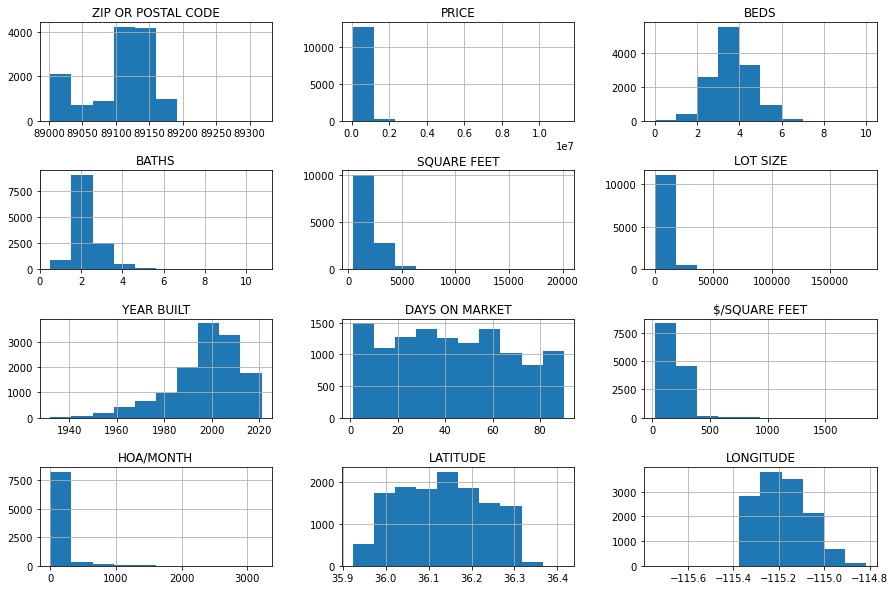

In [26]:
# before I decide how to handle the remaining nans, I'm plotting histograms of all the numeric features
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

I can ignore zipcode here, while it appears to be a numeric feature, it is really categorical. I will look at distribution of price per zipcode a little bit further down

Some interesting insights here:
 - number of beds has a fairly normal distribution
 - it looks like Lot Size, $/Square Feet, and HOA/Month might have some outliers
 - 2 of the columns with missing values are concerning because they clustered at the low end: Lot Size & HOA/Month

In [27]:
#renaming columns
df = df.rename(str.lower, axis='columns')
df = df.rename(columns={'zip or postal code': 'zipcode', 'square feet': 'square_feet', 'lot size': 'lot_size', 'year built': 'year_built', 'days on market': 'days_on_market', '$/square feet': 'price_per_sqft', 'hoa/month': 'hoa_per_mon'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13097 entries, 0 to 157
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         13097 non-null  object 
 1   city            13097 non-null  object 
 2   zipcode         13097 non-null  int64  
 3   price           13097 non-null  int64  
 4   beds            13097 non-null  float64
 5   baths           13097 non-null  float64
 6   square_feet     13097 non-null  float64
 7   lot_size        11606 non-null  float64
 8   year_built      13097 non-null  float64
 9   days_on_market  12019 non-null  float64
 10  price_per_sqft  13097 non-null  float64
 11  hoa_per_mon     8810 non-null   float64
 12  latitude        13097 non-null  float64
 13  longitude       13097 non-null  float64
 14  property_type   13097 non-null  object 
dtypes: float64(10), int64(2), object(3)
memory usage: 1.6+ MB


In [28]:
#looking at summary statistics for columns with Nans
df.describe().T

,count,mean,std,min,25%,50%,75%,max
zipcode,13097.0,89105.531190,47.927214,89002.000000,89081.000000,89119.000000,89139.000000,8.931800e+04
price,13097.0,406626.882187,397254.904222,37000.000000,260000.000000,332000.000000,435000.000000,1.130000e+07
beds,13097.0,3.165916,1.018704,0.000000,3.000000,3.000000,4.000000,1.000000e+01
baths,13097.0,2.415038,0.786291,0.500000,2.000000,2.500000,2.500000,1.075000e+01
square_feet,13097.0,1983.724364,1070.263604,392.000000,1310.000000,1737.000000,2335.000000,2.012000e+04
lot_size,11606.0,6744.558763,6744.428177,1.000000,3920.000000,5663.000000,7405.000000,1.807740e+05
year_built,13097.0,1997.144995,14.881551,1932.000000,1990.000000,2000.000000,2006.000000,2.021000e+03
days_on_market,12019.0,42.751976,25.385321,1.000000,22.000000,42.000000,63.000000,9.000000e+01
price_per_sqft,13097.0,199.282507,71.163550,20.000000,164.000000,189.000000,220.000000,1.853000e+03
hoa_per_mon,8810.0,144.238479,208.896092,1.000000,48.000000,82.000000,180.000000,3.219000e+03


# Dealing with NaNs (Part 2)

## Lot Size - dropping nans and outliers

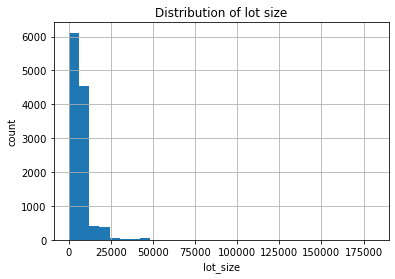

In [29]:
df.lot_size.hist(bins=30)
plt.xlabel('lot_size')
plt.ylabel('count')
plt.title('Distribution of lot size')
plt.show()

In [30]:
df['lot_size'].describe().T

count     11606.000000
mean       6744.558763
std        6744.428177
min           1.000000
25%        3920.000000
50%        5663.000000
75%        7405.000000
max      180774.000000
Name: lot_size, dtype: float64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13097 entries, 0 to 157
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         13097 non-null  object 
 1   city            13097 non-null  object 
 2   zipcode         13097 non-null  int64  
 3   price           13097 non-null  int64  
 4   beds            13097 non-null  float64
 5   baths           13097 non-null  float64
 6   square_feet     13097 non-null  float64
 7   lot_size        11606 non-null  float64
 8   year_built      13097 non-null  float64
 9   days_on_market  12019 non-null  float64
 10  price_per_sqft  13097 non-null  float64
 11  hoa_per_mon     8810 non-null   float64
 12  latitude        13097 non-null  float64
 13  longitude       13097 non-null  float64
 14  property_type   13097 non-null  object 
dtypes: float64(10), int64(2), object(3)
memory usage: 1.6+ MB


In [32]:
#dropping all listings with nans in lot_size
df.dropna(subset=['lot_size'], inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11606 entries, 0 to 157
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         11606 non-null  object 
 1   city            11606 non-null  object 
 2   zipcode         11606 non-null  int64  
 3   price           11606 non-null  int64  
 4   beds            11606 non-null  float64
 5   baths           11606 non-null  float64
 6   square_feet     11606 non-null  float64
 7   lot_size        11606 non-null  float64
 8   year_built      11606 non-null  float64
 9   days_on_market  10679 non-null  float64
 10  price_per_sqft  11606 non-null  float64
 11  hoa_per_mon     7488 non-null   float64
 12  latitude        11606 non-null  float64
 13  longitude       11606 non-null  float64
 14  property_type   11606 non-null  object 
dtypes: float64(10), int64(2), object(3)
memory usage: 1.4+ MB


## Days On Market - replacing nans

In [34]:
df['days_on_market'].describe().T

count    10679.000000
mean        43.005431
std         25.373025
min          1.000000
25%         22.000000
50%         42.000000
75%         63.000000
max         90.000000
Name: days_on_market, dtype: float64

In [35]:
#I've decided to forward fill nans
df['days_on_market'].fillna(method='ffill', inplace=True)

In [36]:
df['days_on_market'].describe().T

count    11606.000000
mean        42.880924
std         25.309591
min          1.000000
25%         22.000000
50%         42.000000
75%         63.000000
max         90.000000
Name: days_on_market, dtype: float64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11606 entries, 0 to 157
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         11606 non-null  object 
 1   city            11606 non-null  object 
 2   zipcode         11606 non-null  int64  
 3   price           11606 non-null  int64  
 4   beds            11606 non-null  float64
 5   baths           11606 non-null  float64
 6   square_feet     11606 non-null  float64
 7   lot_size        11606 non-null  float64
 8   year_built      11606 non-null  float64
 9   days_on_market  11606 non-null  float64
 10  price_per_sqft  11606 non-null  float64
 11  hoa_per_mon     7488 non-null   float64
 12  latitude        11606 non-null  float64
 13  longitude       11606 non-null  float64
 14  property_type   11606 non-null  object 
dtypes: float64(10), int64(2), object(3)
memory usage: 1.4+ MB


## HOA per month - replacing nans

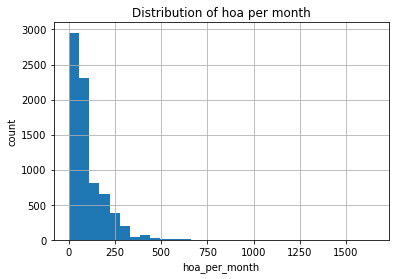

In [38]:
df.hoa_per_mon.hist(bins=30)
plt.xlabel('hoa_per_month')
plt.ylabel('count')
plt.title('Distribution of hoa per month')
plt.show()

In [39]:
#HOA > $1000 per month seems extreme, but I'm going to look at the zipcode column to see if this makes sense
df[df['hoa_per_mon'] > 1000]

,address,city,zipcode,price,beds,baths,square_feet,lot_size,year_built,days_on_market,price_per_sqft,hoa_per_mon,latitude,longitude,property_type
233,2800 High Sail Ct,Las Vegas,89117,2850000,6.0,6.50,10929.0,42689.0,1997.0,30.0,261.0,1006.0,36.140251,-115.287879,SingleFamily
96,9 Mountain Cove Ct,Henderson,89052,3350000,5.0,7.25,8416.0,22216.0,2005.0,15.0,398.0,1480.0,35.964281,-115.078709,SingleFamily
96,2406 Sungold Dr,Las Vegas,89134,435000,2.0,1.75,1653.0,9583.0,1990.0,35.0,263.0,1647.0,36.203981,-115.287578,SingleFamily
275,1701 Enclave Ct,Las Vegas,89134,9600000,4.0,6.50,13349.0,84506.0,1997.0,21.0,719.0,1275.0,36.190295,-115.295890,SingleFamily
294,1641 Enclave Court Ct,Las Vegas,89134,11300000,6.0,8.25,14132.0,113256.0,1999.0,7.0,800.0,1275.0,36.189567,-115.296121,SingleFamily
69,11280 Granite Ridge Dr #1031,Las Vegas,89135,926995,3.0,2.50,2414.0,7405.0,2020.0,39.0,384.0,1002.0,36.113731,-115.337511,Condo/Townhouse
101,11280 Granite Ridge Dr #1094,Las Vegas,89135,1315000,4.0,3.75,3211.0,7405.0,2019.0,43.0,410.0,1002.0,36.113731,-115.337511,Condo/Townhouse
177,11280 Granite Ridge Dr #1085,Las Vegas,89135,1199900,3.0,2.50,2418.0,5227.0,2019.0,49.0,496.0,1002.0,36.113731,-115.337511,Condo/Townhouse
232,11280 Granite Ridge Dr #1022,Las Vegas,89135,925000,3.0,2.50,2414.0,7405.0,2020.0,11.0,383.0,1002.0,36.113731,-115.337511,Condo/Townhouse


In [40]:
null_hoa = df[df['hoa_per_mon'].isna()]
null_hoa['property_type'].value_counts()

SingleFamily       3976
Condo/Townhouse     142
Name: property_type, dtype: int64

In [41]:
df['hoa_per_mon'].describe().T

count    7488.000000
mean      102.134749
std        99.985680
min         1.000000
25%        42.000000
50%        67.000000
75%       137.250000
max      1647.000000
Name: hoa_per_mon, dtype: float64

In [42]:
# since it looks like there might be quite a few outliers in this column, I'm going to use median to fillna; 
# it is possible that some of these homes don't have HOA fees, but that is very rare in the Las Vegas area,
# so I've decided not to fill with zero
df['hoa_per_mon'] = df['hoa_per_mon'].fillna(value = df['hoa_per_mon'].median())
df['hoa_per_mon'].describe().T

count    11606.000000
mean        89.668361
std         82.050587
min          1.000000
25%         55.000000
50%         67.000000
75%         86.000000
max       1647.000000
Name: hoa_per_mon, dtype: float64

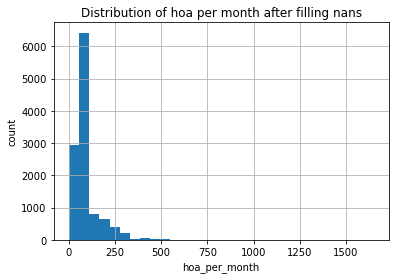

In [43]:
df.hoa_per_mon.hist(bins=30)
plt.xlabel('hoa_per_month')
plt.ylabel('count')
plt.title('Distribution of hoa per month after filling nans')
plt.show()

In [44]:
#checking to make sure I took care of all the nans
df.isna().sum()

address           0
city              0
zipcode           0
price             0
beds              0
baths             0
square_feet       0
lot_size          0
year_built        0
days_on_market    0
price_per_sqft    0
hoa_per_mon       0
latitude          0
longitude         0
property_type     0
dtype: int64

In [45]:
#double checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11606 entries, 0 to 157
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         11606 non-null  object 
 1   city            11606 non-null  object 
 2   zipcode         11606 non-null  int64  
 3   price           11606 non-null  int64  
 4   beds            11606 non-null  float64
 5   baths           11606 non-null  float64
 6   square_feet     11606 non-null  float64
 7   lot_size        11606 non-null  float64
 8   year_built      11606 non-null  float64
 9   days_on_market  11606 non-null  float64
 10  price_per_sqft  11606 non-null  float64
 11  hoa_per_mon     11606 non-null  float64
 12  latitude        11606 non-null  float64
 13  longitude       11606 non-null  float64
 14  property_type   11606 non-null  object 
dtypes: float64(10), int64(2), object(3)
memory usage: 1.4+ MB


# Data Definitions

## property_type
<br><b>description:</b> type of property that is listed

In [46]:
df['property_type'].describe().T

count            11606
unique               2
top       SingleFamily
freq             10062
Name: property_type, dtype: object

In [47]:
df['property_type'].value_counts()

SingleFamily       10062
Condo/Townhouse     1544
Name: property_type, dtype: int64

## address
<br><b>description:</b> address of listing (no duplicates)

In [48]:
df['address'].describe().T

count                     11606
unique                    11606
top       368 Calabria Beach St
freq                          1
Name: address, dtype: object

## city
<br><b>description:</b> city of listed property

In [49]:
df['city'].value_counts()

Las Vegas          8139
Henderson          2113
North Las Vegas    1238
Boulder City        112
Blue Diamond          2
Enterprise            2
Name: city, dtype: int64

## zipcode
<br><b>description:</b> zipcode of listed property

In [50]:
df['zipcode'].value_counts()

89052    425
89031    410
89149    354
89117    350
89148    348
        ... 
89085     20
89124      7
89004      2
89318      1
89161      1
Name: zipcode, Length: 61, dtype: int64

## price
<br><b>description:</b> listing price of property

In [51]:
df['price'].describe().T

count    1.160600e+04
mean     4.248243e+05
std      3.963848e+05
min      4.500000e+04
25%      2.800000e+05
50%      3.450000e+05
75%      4.475000e+05
max      1.130000e+07
Name: price, dtype: float64

## beds
<br><b>description:</b> number of bedrooms

In [52]:
df['beds'].describe().T

count    11606.000000
mean         3.336292
std          0.922431
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: beds, dtype: float64

In [53]:
df['beds'].value_counts()

3.0     5341
4.0     3316
2.0     1710
5.0      965
6.0      149
1.0       94
7.0       18
8.0        7
0.0        4
9.0        1
10.0       1
Name: beds, dtype: int64

## baths
<br><b>description:</b> number of bathrooms

In [54]:
df['baths'].describe().T

count    11606.000000
mean         2.498600
std          0.774738
min          0.500000
25%          2.000000
50%          2.500000
75%          2.750000
max         10.750000
Name: baths, dtype: float64

In [55]:
df['baths'].value_counts()

2.50     3597
2.00     3184
3.00     1177
1.75      895
2.75      562
3.50      540
2.25      303
1.00      276
4.50      225
1.50      172
4.00      168
3.25      155
3.75       86
4.25       55
5.50       49
5.00       37
5.25       24
6.00       18
6.50       15
4.75       13
0.75        9
7.50        8
6.25        7
5.75        7
1.25        5
7.00        5
7.25        3
7.75        3
6.75        2
8.25        2
0.50        1
10.75       1
10.50       1
8.75        1
Name: baths, dtype: int64

## square_feet
<br><b>description:</b> total square footage of listing

In [56]:
df['square_feet'].describe().T

count    11606.000000
mean      2094.207996
std       1074.379340
min        392.000000
25%       1434.000000
50%       1833.000000
75%       2436.750000
max      20120.000000
Name: square_feet, dtype: float64

In [57]:
df['square_feet'].value_counts()

2096.0    28
1247.0    27
1188.0    26
1570.0    26
1768.0    24
          ..
3605.0     1
2981.0     1
8844.0     1
3953.0     1
4162.0     1
Name: square_feet, Length: 3004, dtype: int64

## lot_size
<br><b>description:</b> total lot size of property

In [58]:
df['lot_size'].describe().T

count     11606.000000
mean       6744.558763
std        6744.428177
min           1.000000
25%        3920.000000
50%        5663.000000
75%        7405.000000
max      180774.000000
Name: lot_size, dtype: float64

In [59]:
df['lot_size'].value_counts()

6098.0    977
4356.0    831
4792.0    736
6534.0    709
3920.0    656
         ... 
1190.0      1
2239.0      1
4605.0      1
3484.0      1
1159.0      1
Name: lot_size, Length: 557, dtype: int64

## year_built
<br><b>description:</b> year that house was built

In [60]:
df['year_built'].describe().T

count    11606.000000
mean      1997.252369
std         15.414491
min       1932.000000
25%       1990.000000
50%       2000.000000
75%       2006.000000
max       2021.000000
Name: year_built, dtype: float64

In [61]:
df['year_built'].value_counts()

2005.0    614
2006.0    600
2004.0    564
2001.0    451
2007.0    434
         ... 
1933.0      1
1937.0      1
1934.0      1
1939.0      1
1945.0      1
Name: year_built, Length: 89, dtype: int64

## days_on_market
<br><b>description:</b> total number of days since listing was posted on Redfin

In [62]:
df['days_on_market'].describe().T

count    11606.000000
mean        42.880924
std         25.309591
min          1.000000
25%         22.000000
50%         42.000000
75%         63.000000
max         90.000000
Name: days_on_market, dtype: float64

In [63]:
df['days_on_market'].value_counts()

56.0    343
23.0    283
84.0    252
35.0    241
49.0    241
       ... 
13.0     50
48.0     44
69.0     42
76.0     28
67.0     12
Name: days_on_market, Length: 90, dtype: int64

## price_per_sqft
<br><b>description:</b> price per square foot

In [64]:
df['price_per_sqft'].describe().T

count    11606.000000
mean       197.187403
std         55.245046
min         20.000000
25%        166.000000
50%        190.000000
75%        219.000000
max        800.000000
Name: price_per_sqft, dtype: float64

In [65]:
df['price_per_sqft'].value_counts()

174.0    144
179.0    141
187.0    135
185.0    133
180.0    129
        ... 
547.0      1
428.0      1
408.0      1
341.0      1
466.0      1
Name: price_per_sqft, Length: 427, dtype: int64

## hoa_per_mon
<br><b>description:</b> monthly cost of HOA

In [66]:
df['hoa_per_mon'].describe().T

count    11606.000000
mean        89.668361
std         82.050587
min          1.000000
25%         55.000000
50%         67.000000
75%         86.000000
max       1647.000000
Name: hoa_per_mon, dtype: float64

In [67]:
df['hoa_per_mon'].value_counts()

67.0      4201
50.0       252
55.0       166
65.0       148
40.0       148
          ... 
500.0        1
451.0        1
1006.0       1
412.0        1
337.0        1
Name: hoa_per_mon, Length: 370, dtype: int64

## latitude
<br><b>description:</b> standard measure of angular distance from the equator (north to south)

In [68]:
df['latitude'].describe().T

count    11606.000000
mean        36.132574
std          0.103651
min         35.922945
25%         36.040993
50%         36.136090
75%         36.217006
max         36.414957
Name: latitude, dtype: float64

## longitude
<br><b>description:</b> standard measure of angular distance from the prime meridian (east to west)

In [69]:
df['longitude'].describe().T

count    11606.000000
mean      -115.180320
std          0.110392
min       -115.746375
25%       -115.274168
50%       -115.193285
75%       -115.100375
max       -114.815042
Name: longitude, dtype: float64

# OneHotEncoding Categorical Data

## property_type

In [70]:
# OneHotEncoding the property_type column
X_property = df['property_type']
encoder = ce.OneHotEncoder(cols=['property_type'])
X_clean_property = encoder.fit_transform(X_property)
encoder.get_feature_names()
X_clean_property.value_counts()

C:\Users\willi\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


property_type_1  property_type_2
1                0                  10062
0                1                   1544
dtype: int64

In [71]:
X_clean_property = X_clean_property.rename(columns={'property_type_1':'propertytype_singlefamily', 'property_type_2': 'propertytype_condo/townhouse'})
X_clean_property.head()

,propertytype_singlefamily,propertytype_condo/townhouse
0,1,0
1,1,0
2,1,0
3,1,0
4,0,1


In [72]:
df_clean = pd.concat([df, X_clean_property], axis=1)

In [73]:
#since there are only 2 categories (condo/townhouse and singlefamily, I don't need both columns, so I'm dropping condo/townhouse)
df_clean = df_clean.drop(columns=['propertytype_condo/townhouse'])
df_clean.head()

,address,city,zipcode,price,beds,baths,square_feet,lot_size,year_built,days_on_market,price_per_sqft,hoa_per_mon,latitude,longitude,property_type,propertytype_singlefamily
0,9329 Sienna Vista Dr,Las Vegas,89117,621500,4.0,2.50,2352.0,6098.0,1994.0,19.0,264.0,146.0,36.154483,-115.297871,SingleFamily,1
1,3358 Wardlaw St,Las Vegas,89117,400000,4.0,3.00,1883.0,3920.0,1995.0,44.0,212.0,67.0,36.128126,-115.263408,SingleFamily,1
2,3367 Ceremony Dr,Las Vegas,89117,339000,4.0,2.50,2230.0,4356.0,1995.0,44.0,152.0,67.0,36.127931,-115.263037,SingleFamily,1
3,1680 City View Ct,Las Vegas,89117,818000,4.0,5.00,4863.0,20038.0,1993.0,44.0,168.0,67.0,36.151716,-115.268710,SingleFamily,1
4,972 Prestwick St,Las Vegas,89145,335000,3.0,2.75,1613.0,2614.0,2001.0,39.0,208.0,175.0,36.160917,-115.294868,Condo/Townhouse,0


In [74]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11606 entries, 0 to 157
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   address                    11606 non-null  object 
 1   city                       11606 non-null  object 
 2   zipcode                    11606 non-null  int64  
 3   price                      11606 non-null  int64  
 4   beds                       11606 non-null  float64
 5   baths                      11606 non-null  float64
 6   square_feet                11606 non-null  float64
 7   lot_size                   11606 non-null  float64
 8   year_built                 11606 non-null  float64
 9   days_on_market             11606 non-null  float64
 10  price_per_sqft             11606 non-null  float64
 11  hoa_per_mon                11606 non-null  float64
 12  latitude                   11606 non-null  float64
 13  longitude                  11606 non-null  float

# Saving cleaned data

In [75]:
#saving the cleaned data to a new csv file in the '../data/interim' subfolder
df_clean.to_csv('../data/interim/redfin_data_cleaned.csv')